# Disclaimer
This cheatsheet is for people who already have some ML/DL experience as it does not explain the concepts in detail. It is meant to be a quick reference guide for the most common operations in PyTorch. Code that are self-descriptive will not be elaborated on.

> Idhibhat Pankam 6532203021

In [ ]:
from datasets import load_dataset
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
from transformers import ViTForImageClassification
import random
from PIL import ImageDraw, ImageFont, Image
import torch
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from sklearn.metrics import  classification_report

# Image Classification with HuggingFace (Vision Transformer)
- images can be split into patches and flattened like tokenizing a sentence
- ViT uses the flattened patches as input tokens for classification

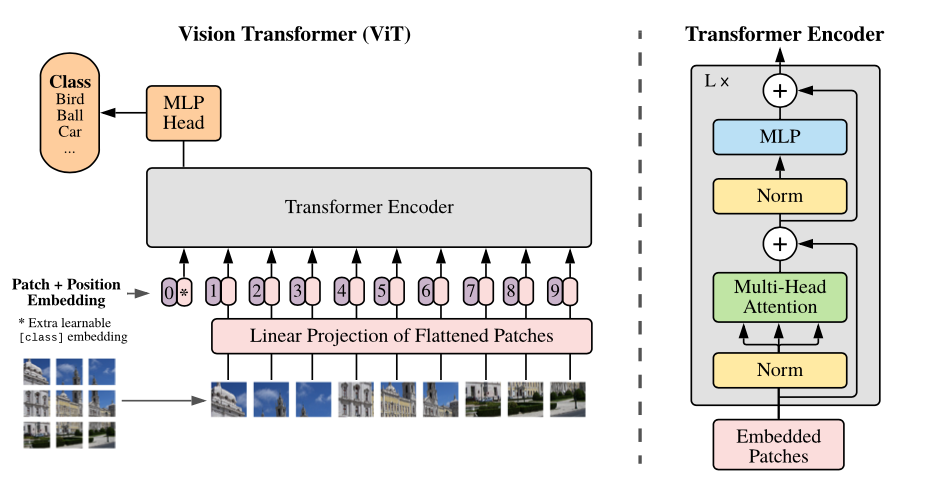

In [ ]:
# load bean leaves dataset
ds = load_dataset('beans',)
labels = ds['train'].features['labels']

In [ ]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

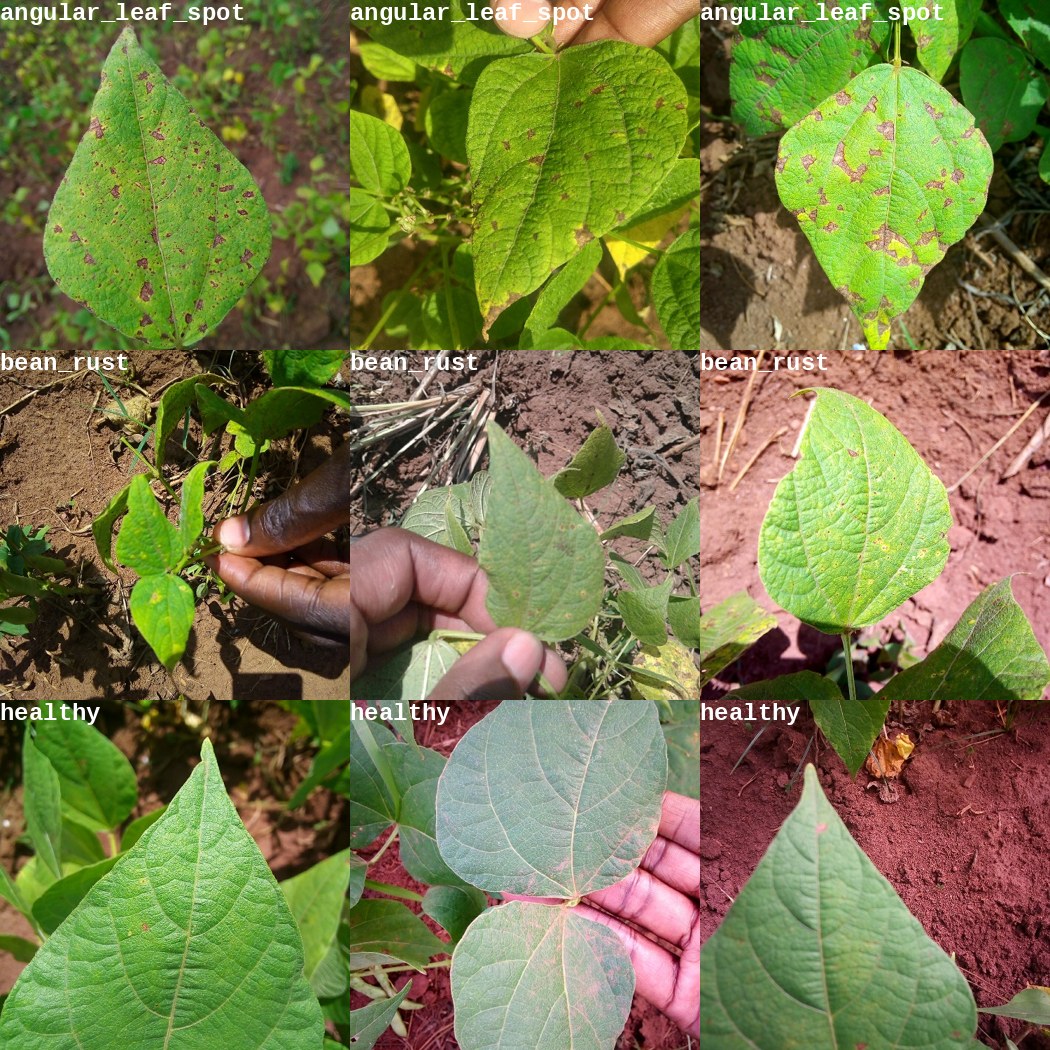

In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224'
# When ViT models are trained, specific transformations are applied to images being fed into them.
#  Use the wrong transformations on your image and the model won't be able to understand what it's seeing 
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

## Training/Eval
- collate function
- eval metrics in `compute_metrics`
- load pretrained model to fine-tune
- eval on fine-tuned model

In [ ]:
def collate_fn(batch):
    return { 'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
             'labels': torch.tensor([x['labels'] for x in batch])}

metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                   num_labels=len(labels),
                                                   ignore_mismatched_sizes=True)

training_args = TrainingArguments(
  output_dir="vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy='epoch',
  logging_steps=1,
  num_train_epochs=10,
  optim='adamw_torch',
  learning_rate=1e-5,
  # IMPORTANT: makes it easier to unpack inputs using the unused feature `image`
  remove_unused_columns=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  metric_for_best_model="loss",
  seed=0
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
# before fine-tuning
test_predictions = trainer.predict(prepared_ds['test'])
# For each prediction, create the label with argmax
predictions = np.argmax(test_predictions[0], axis=1)
# Retrieve reference labels from test set
test_labels = np.array(prepared_ds["test"][:]["labels"])
print(classification_report(test_labels, predictions, target_names=['angular_leaf_spot', 'bean_rust', 'healthy'], digits=4))

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

### training metrics
- epoch                    =        10.0
- total_flos               = 746244894GF
- train_loss               =      0.0814
- train_runtime            =  0:08:52.25
- train_samples_per_second =      19.427
- train_steps_per_second   =       1.221

### eval metrics 
- epoch                       =       10.0
- eval_accuracy               =     0.9925
- eval_loss                   =     0.0265
- eval_model_preparation_time =     0.0196
- eval_runtime                = 0:00:02.39
- eval_samples_per_second     =     55.631
- eval_steps_per_second       =      3.764

### Before fine-tuning (macro avg)
- precision: 0.2318
- recall: 0.2578
- f1: 0.1856

### After fine-tuning (macro avg)
- precision: 0.9924
- recall: 0.9922
- f1: 0.9922